<a href="https://colab.research.google.com/github/Molten-Ice/3dGolfPoseDetection/blob/colab/dev-nbs/12-tensorboard-working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Apr 29 14:58:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
test_name = 'augmented_1k_cropped'

In [3]:
!tensorboard dev export --outdir tensorboard_experiments

2023-04-29 14:58:45.886753: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 14:58:47.255126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-29 14:58:50.578881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-29 14:58:51.199253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returnin

In [4]:
import os
import json

project = 'golf2d'
most_recent_foldername = None
run_idx = 0
for foldername in os.listdir('tensorboard_experiments'):
    metadata_path = f'tensorboard_experiments/{foldername}/metadata.json'
    with open(metadata_path) as f:
        metadata = json.load(f)
    if metadata['name'].split('_')[0] == project:
        found_run_idx = int(metadata['name'].split('_')[1])
        if found_run_idx >= run_idx:
            run_idx = found_run_idx
            most_recent_foldername = foldername
            print(f"Most recent experiment: {metadata['name']} | {foldername}")

run_idx+=1
print(f"Starting on run_idx: {run_idx}")

Most recent experiment: golf2d_2_2_augmented_1k | experiment_66gBMcqeRDWJJOXziQirQQ
Most recent experiment: golf2d_2_2_augmented_1k | experiment_mz8wS8vcR3OCqLQeZnlgXw
Starting on run_idx: 3


In [5]:
%load_ext tensorboard

In [6]:
from torch.utils.tensorboard import SummaryWriter
#put grip, first e.g. grip_test, head_test, to make the graphs so in the right oder
layout = {
    "ABCDE": {
        "accuracy": ["Multiline", ["accuracy/bbox", "accuracy/grip", "accuracy/head"]],
        "losses" : ["Multiline", ["losses/loss_keypoint", "losses/loss_classifier", "losses/loss_objectness", "losses/loss_box_reg", "losses/loss_rpn_box_reg"]],
        "hyperparameters": ["Multiline", ["hyperparameters/lrs"]],
    },
}

test_name = f'{run_idx}_{test_name}'

# default `log_dir` is "runs" - we'll be more specific here
writer_train = SummaryWriter(f'runs/{test_name}/train')
writer_test = SummaryWriter(f'runs/{test_name}/test')
writer_train.add_custom_scalars(layout)
writer_test.add_custom_scalars(layout)

In [7]:
import torch
import torchvision
import torch.nn as nn
import albumentations as A # Library for augmentations
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

import os
import cv2
import json
import time
import random
import argparse
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps


# repo_dir = "c:/Users/James/git/3dGolfPoseDetection/"
# repo_dir = "/home/fsuser/3dGolfPoseDetection/"
repo_dir = "/content/"
data_path = repo_dir + "downloaded-data/"

if not os.path.exists(data_path): 
    print("Creating folder: ", data_path)
    os.mkdir(data_path)

Creating folder:  /content/downloaded-data/


In [8]:
### Download data from kaggle on google colab) ###

import json
import zipfile
kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}

if not os.path.exists('/root/.kaggle'): os.mkdir('/root/.kaggle')
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_apikey, f)

! chmod 600 ~/.kaggle/kaggle.json

!kaggle config set -n path -v {data_path}

## Download and unzip data ##

! kaggle datasets download jamesdavey/labelled-golf-clubs
zip_path = data_path+"datasets/jamesdavey/labelled-golf-clubs/labelled-golf-clubs.zip"
with zipfile.ZipFile(zip_path,"r") as zip_ref:
    zip_ref.extractall(data_path)

- path is now set to: /content/downloaded-data/
 99% 667M/671M [00:19<00:00, 34.1MB/s]
100% 671M/671M [00:19<00:00, 36.8MB/s]


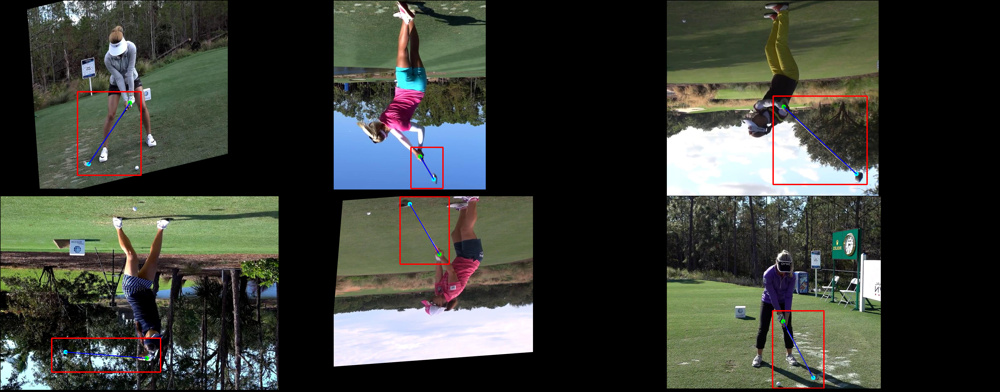

In [9]:
class GolfDataset(torch.utils.data.Dataset):
    def __init__(self, save_dir, filenames, annotate = False, padding = False, augment = False):
        self.save_dir = save_dir
        self.filenames = filenames
        self.annotate = annotate
        self.img_transforms = transforms.ToTensor()
        self.padding = padding
        self.augment = augment

        self.max_augmentation_attempts = 10
        self.albumentations_transform = A.Compose(
            [A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Affine(p=0.5)],
            keypoint_params=A.KeypointParams(format='xy'))
        
    # A.OneOf([
    #                 A.HueSaturationValue(p=0.5), 
    #                 A.RGBShift(p=0.7)
    #             ], p=0.5),                          
    #         A.RandomBrightnessContrast(p=0.5),
    #         A.Rotate(p=1),
    #         A.ShiftScaleRotate(p=0.5)], 

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img = cv2.imread(self.save_dir+filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cords = [int(x) for x in filename.split("_")[1].split("-")]
        grip, head = cords[:2], cords[2:]

        if self.augment:
            for i in range(self.max_augmentation_attempts): # 10 attempts to crop keypoints within, otherwise use original img
                transformed = self.albumentations_transform(image=img, keypoints=[grip, head])
                if len(transformed['keypoints']) == 2: # keypoint has not been cropped out
                    # print(f"Both keypoints found, after {i} tries")
                    img = transformed['image']
                    grip, head = transformed['keypoints']
                    break
            grip, head = [int(x) for x in grip], [int(x) for x in head]

        box_buffer = max(img.shape[:2])//20
        box_cords = [
            max(min(grip[0], head[0])-box_buffer, 1),
            max(min(grip[1], head[1])-box_buffer, 1), #top left cord
            min(max(grip[0], head[0])+box_buffer, img.shape[1]-1), # shape[0] is y
            min(max(grip[1], head[1])+box_buffer, img.shape[0]-1)] # bottom right cord

        if self.annotate:
            cv2.circle(img, grip, 8, (0,255,0), -1)
            cv2.circle(img, head, 8, (0,255,255), -1)
            cv2.line(img, head, grip, (0, 0, 255), 2)
            cv2.rectangle(img, box_cords[:2], box_cords[2:], (255, 0, 0), 4)

        if self.padding:
            max_height, max_width = 720, 1225
            height, width = img.shape[:2]
            img = cv2.copyMakeBorder(img, 0, max_height-height, 0, max_width-width, cv2.BORDER_CONSTANT)

        # During training, the model expects both the input tensors and targets (list of dictionary), containing:
        # boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
        # labels (Int64Tensor[N]): the class label for each ground-truth box
        # keypoints (FloatTensor[N, K, 3]): the K keypoints location for each of the N instances, in the format [x, y, visibility], where visibility=0 means that the keypoint is not visible.
        target = {}
        target["boxes"] = torch.Tensor(box_cords).unsqueeze(dim=0).type(torch.FloatTensor)
        target["labels"] = torch.Tensor(torch.ones(1)).type(torch.int64)
        target["keypoints"] = torch.Tensor([grip + [1.], head + [1.]]).unsqueeze(dim=0).type(torch.FloatTensor)

        img = Image.fromarray(img)
        img = self.img_transforms(img)
        return img, target
    
def collate_fn(batch):
    return tuple(zip(*batch))

batch_size = 6

images_dir = data_path + "saved-labels/"
filenames = sorted(os.listdir(images_dir))[:10]

temp_dataset = GolfDataset(images_dir, filenames, annotate = True, padding = True, augment = True)
test_dataloader = torch.utils.data.DataLoader(temp_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)

temp_batch = next(iter(test_dataloader))
torch_grid = torchvision.utils.make_grid(torch.stack(temp_batch[0],dim=0).cpu(), nrow = 3)
display_img = Image.fromarray((torch_grid.permute(1,2,0).numpy()*255).astype(np.uint8))
display(ImageOps.contain(display_img, (1000, 1000)))

In [10]:
def evaluate_model(model, dataloader):
    box_diffs = []
    keypoint_diffs = []
    total_elements = 0

    t_start = time.time()
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            images = [img.to(device) for img in batch[0]]
            targets = [{key: d[key].to(device) for key in d.keys()} for d in batch[1]]
            preds = model(images)

            total_elements+=len(preds)
            for idx in range(len(preds)):
                predicted_boxes = preds[idx]['boxes']
                predicted_clubs = preds[idx]['keypoints']
                if len(predicted_boxes) > 0:
                    real_box = targets[idx]['boxes'][0]
                    box_diffs.append(torch.abs(predicted_boxes[0] - real_box))

                if len(predicted_clubs) > 0:
                    real_keypoints = targets[idx]['keypoints'][0]
                    keypoint_diffs.append(torch.abs(predicted_clubs[0] - real_keypoints)[:,:2])
    model.train()

    if len(box_diffs) == 0:
        average_box_diff = ['inf', 'inf', 'inf', 'inf']
        boxes_predicted = 0
    else:
        stacked_boxes = torch.stack(box_diffs,dim=0).cpu().numpy()
        average_box_diff = np.mean(stacked_boxes, axis=0)
        boxes_predicted = stacked_boxes.shape[0]

    if len(keypoint_diffs) == 0:
        average_club_diff = ['inf', 'inf', 'inf']
        keypoints_predicted = 0
    else:
        stacked_keypoints = torch.stack(keypoint_diffs,dim=0).cpu().numpy() #[[(x_grip, y_grip), (x_club, y_club)],...]
        average_keypoint_diff = np.mean(stacked_keypoints, axis=0)
        keypoints_predicted = stacked_keypoints.shape[0]

    return average_box_diff, average_keypoint_diff, total_elements, boxes_predicted, keypoints_predicted, time.time()-t_start

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = keypointrcnn_resnet50_fpn(weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()
out = nn.ConvTranspose2d(512, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
model.roi_heads.keypoint_predictor.kps_score_lowres = out
model = model.to(device)

#freeze parameters in backbone
for param in model.backbone.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:04<00:00, 56.5MB/s]


In [12]:
batch_size = 8

images_dir = data_path + "saved-labels/"
filenames = sorted(os.listdir(images_dir))[:12]

train_test_split = 0.8
split_index = int(len(filenames)*train_test_split)
train_filenames, test_filenames = filenames[:split_index], filenames[split_index:]

train_dataset = GolfDataset(images_dir, train_filenames, annotate = False, padding = False, augment = False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)

test_dataset = GolfDataset(images_dir, test_filenames, annotate = False, padding = False, augment = False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)

#note len(train_dataloader) > 1 otherwise % breaks
print(f"Dataset lengths | train {len(train_dataset)}, test {len(test_dataset)}")
print(f"Dataloader #batches | train {len(train_dataloader)}, test {len(test_dataloader)}, batches of size {batch_size}")

Dataset lengths | train 9, test 3
Dataloader #batches | train 2, test 1, batches of size 8


In [13]:
### Hyperparameters ###

epochs = 9
lr = 3e-4
eval_interval = 2

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=lr)
lr_scheduler_epochs = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

# Starting evaluation
# for split, dataloader in zip(["train", "test","train_clean"], [train_dataloader, test_dataloader, train_dataloader_clean]):
for split, dataloader, writer in zip(["train", "test"], [train_dataloader, test_dataloader], [writer_train, writer_test]):
    average_box_diff, average_keypoint_diff, total_elements, boxes_predicted, clubs_predicted, time_taken = evaluate_model(model, dataloader)
    print(f"{split} Evaluation | bbox: {average_box_diff.mean():.2f}, grip: {average_keypoint_diff[0].mean():.2f}, head: {average_keypoint_diff[1].mean():.2f} | bbox: [{boxes_predicted}/{total_elements}], keypoints: [{clubs_predicted}/{total_elements}], Time taken: {time_taken:.2f}s")
    writer.add_scalar("accuracy/bbox", average_box_diff.mean(), 0)
    writer.add_scalar("accuracy/grip", average_keypoint_diff[0].mean(), 0)
    writer.add_scalar("accuracy/head", average_keypoint_diff[1].mean(), 0)

### Training loop ###

training_iteration = 0
t_start = time.time()
model.train()
for epoch in range(epochs):
    print(f"--------- EPOCH {epoch} ---------")
    if epoch == 0: # learning rate warmup
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(train_dataloader) - 1)
        lr_scheduler_warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=warmup_factor, total_iters=warmup_iters)

    for batch_idx, batch in enumerate(train_dataloader):
        images = [img.to(device) for img in batch[0]]
        targets = [{key: d[key].to(device) for key in d.keys()} for d in batch[1]]

        losses_dict = model(images, targets)
        total_loss = sum([losses_dict[key] for key in losses_dict.keys()])
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if epoch == 0: # this REALLY should be before the first batch (change after first test)
            lr_scheduler_warmup.step()

        writer_train.add_scalar("hyperparameters/lrs", optimizer.param_groups[0]['lr'], training_iteration)
        for key in losses_dict.keys():
            writer_train.add_scalar(f"losses/{key}", losses_dict[key].item(), training_iteration)
        training_iteration+=1

        if batch_idx % (len(train_dataloader)//2) == 0:
            print(f"Epoch [{epoch+1}/{epochs}], batch [{batch_idx+1}/{len(train_dataloader)}] | Total loss: {total_loss.item():.2f}, Time: {time.time()-t_start:.2f}s | {''.join([f'{key}: {losses_dict[key].item():.4f}, ' for key in losses_dict.keys()])}")

    lr_scheduler_epochs.step()

    if epoch % eval_interval == 0:   
        # for split, dataloader in zip(["train", "test","train_clean"], [train_dataloader, test_dataloader, train_dataloader_clean]):
        for split, dataloader, writer in zip(["train", "test"], [train_dataloader, test_dataloader], [writer_train, writer_test]):
            average_box_diff, average_keypoint_diff, total_elements, boxes_predicted, clubs_predicted, time_taken = evaluate_model(model, dataloader)
            print(f"{split} Evaluation | bbox: {average_box_diff.mean():.2f}, grip: {average_keypoint_diff[0].mean():.2f}, head: {average_keypoint_diff[1].mean():.2f} | bbox: [{boxes_predicted}/{total_elements}], keypoints: [{clubs_predicted}/{total_elements}], Time taken: {time_taken:.2f}s")
            writer.add_scalar("accuracy/bbox", average_box_diff.mean(), epoch + 1)
            writer.add_scalar("accuracy/grip", average_keypoint_diff[0].mean(), epoch + 1)
            writer.add_scalar("accuracy/head", average_keypoint_diff[1].mean(), epoch + 1)

print(f"Total time: {time.time()-t_start:.2f}s")
writer.close()

train Evaluation | bbox: 160.69, grip: 80.22, head: 221.93 | bbox: [9/9], keypoints: [9/9], Time taken: 7.40s
test Evaluation | bbox: 108.67, grip: 56.66, head: 129.30 | bbox: [3/3], keypoints: [3/3], Time taken: 0.34s
--------- EPOCH 0 ---------
Epoch [1/9], batch [1/2] | Total loss: 10.87, Time: 2.18s | loss_classifier: 0.2377, loss_box_reg: 0.0866, loss_keypoint: 10.4307, loss_objectness: 0.1085, loss_rpn_box_reg: 0.0057, 
Epoch [1/9], batch [2/2] | Total loss: 9.96, Time: 2.36s | loss_classifier: 0.3661, loss_box_reg: 0.1449, loss_keypoint: 9.3259, loss_objectness: 0.1178, loss_rpn_box_reg: 0.0045, 
train Evaluation | bbox: 172.13, grip: 73.73, head: 243.90 | bbox: [9/9], keypoints: [9/9], Time taken: 2.51s
test Evaluation | bbox: 154.39, grip: 60.42, head: 179.27 | bbox: [3/3], keypoints: [3/3], Time taken: 0.62s
--------- EPOCH 1 ---------
Epoch [2/9], batch [1/2] | Total loss: 6.70, Time: 6.89s | loss_classifier: 0.1527, loss_box_reg: 0.0694, loss_keypoint: 6.3963, loss_objectne

In [14]:
torch.cuda.empty_cache()

In [16]:
### plot all previous experiments for this project ###
if most_recent_foldername is not None:
    print("Loading previous runs")

    print(f"Starting on run_idx: {run_idx}")
    scalars_path = f'tensorboard_experiments/{most_recent_foldername}/scalars.json'
    scalars_data = []
    with open(scalars_path) as f:
        for line in f:
            scalars_data.append(json.loads(line))

    current_run = ''
    for row in scalars_data:
        if row['run'] != current_run:
            print(f"Starting new run: {row['run']}")
            current_run = row['run']
            writer = SummaryWriter(f"runs/{row['run']}")
            writer.add_custom_scalars(layout)

        for value, iteration, wall_time in zip(row['points']['values'], row['points']['steps'], row['points']['wall_times']):
            writer.add_scalar(row['tag'], average_box_diff.mean(), epoch + 1, walltime = wall_time)

Loading previous runs
Starting on run_idx: 3
Starting new run: 2_augmented_1k/test
Starting new run: 2_augmented_1k/train
Starting new run: original_1k/train


In [16]:
%tensorboard --logdir runs

In [28]:
save_name = f"{project}_{test_name}"

!tensorboard dev upload --logdir ./runs \
  --name {save_name} \
  --description "Uploading results" \
  --one_shot 

2023-04-29 15:10:47.292305: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/bgA876T9Qi23N6qMDSm9Pg/

[2023-04-29T15:10:49] Started scanning logdir.
[2023-04-29T15:10:50] Total uploaded: 294 scalars, 0 tensors, 0 binary objects
[2023-04-29T15:10:50] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/bgA876T9Qi23N6qMDSm9Pg/


In [18]:
# def label_pred(tensor_img, box, keypoints):
    
#     img = (tensor_img*255).type(torch.uint8).permute(1,2,0).cpu().numpy()
#     labelled = img[: , : , ::-1].copy().astype(np.uint8)

#     box_cords = [int(x) for x in box]
#     cv2.rectangle(labelled, box_cords[:2], box_cords[2:], (124,252,0), 3)

#     grip, club = keypoints
#     grip = [int(x) for x in grip[:2]]
#     club = [int(x) for x in club[:2]]
#     cv2.circle(labelled, grip, 5, (200, 0, 0), -1)
#     cv2.circle(labelled, club, 5, (200, 0, 0), -1)
#     cv2.line(labelled, club[:2], grip[:2], (0, 128, 255), 2)

#     max_height, max_width = 720, 1225
#     height, width = labelled.shape[:2]
#     labelled = cv2.copyMakeBorder(labelled, 0, max_height-height, 0, max_width-width, cv2.BORDER_CONSTANT)

#     labelled = labelled[:,:,::-1]
#     return labelled.copy()

In [19]:
# def generate_predictions(model, dataloader, imgs_to_generate = 16):

#     img_transforms = transforms.ToTensor()
#     labelled_images = []

#     model.eval()
#     with torch.no_grad():
#         for batch_idx, batch in enumerate(dataloader):
#             if len(labelled_images) >= imgs_to_generate:
#                 break

#             images = [img.to(device) for img in batch[0]]
#             targets = batch[1] # [{key: d[key].to(device) for key in d.keys()} for d in batch[1]]
#             preds = model(images)

#             for idx in range(len(preds)):
#                 predicted_boxes = preds[idx]['boxes']
#                 predicted_clubs = preds[idx]['keypoints']

#                 if not (len(predicted_boxes > 0) and len(predicted_clubs > 0)):
#                     print(f"Skipping {idx} box/club not predicted")
#                     continue

#                 predicted_box = predicted_boxes[0].cpu()
#                 predicted_club = predicted_clubs[0].cpu()
#                 tensor_img = images[idx]

#                 labelled_img = Image.fromarray(label_pred(tensor_img, predicted_box, predicted_club))
#                 labelled_images.append(img_transforms(labelled_img))
    
#                 if len(labelled_images) >= imgs_to_generate:
#                     break
#     return labelled_images

In [20]:
# labelled_images = generate_predictions(model, train_dataloader)
# display_img = Image.fromarray((torchvision.utils.make_grid(torch.stack(labelled_images, dim=0), padding=0, nrow = 4, normalize=False).permute(1,2,0).numpy()*255).astype(np.uint8))
# display(ImageOps.contain(display_img, (1500, 1500)))

In [21]:
# labelled_images = generate_predictions(model, train_dataloader_clean)
# display_img = Image.fromarray((torchvision.utils.make_grid(torch.stack(labelled_images, dim=0), padding=0, nrow = 4, normalize=False).permute(1,2,0).numpy()*255).astype(np.uint8))
# display(ImageOps.contain(display_img, (1500, 1500)))

In [22]:
# labelled_images = generate_predictions(model, test_dataloader)
# display_img = Image.fromarray((torchvision.utils.make_grid(torch.stack(labelled_images, dim=0), padding=0, nrow = 4, normalize=False).permute(1,2,0).numpy()*255).astype(np.uint8))
# display(ImageOps.contain(display_img, (1500, 1500)))

In [23]:
# Get worse performing train/test examples, to try and spot what they could be missing